# Comic Book Cancellations Part II: Machine Learning

In the [first part](./1 Comic Book Cancellations - Web Scrapping.ipynb) of this series, Marvel comic book sales information from 1998 and alter was scrapped from the web and cleaned up and stored into a database file. In this section, we will use machine learning on that database in order to determine what criteria causes books to get cancelled.

# 1. Preliminary Analysis

## Imports

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.gaussian_process.kernels import RBF
from sklearn import neighbors, datasets, discriminant_analysis, svm, tree, naive_bayes,gaussian_process, linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from subprocess import check_call
from IPython.display import Image

%matplotlib inline

## Load Data

In [3]:
db = sqlite3.connect('sales.db')

# Load web scrapped data from SQL database for Marvel comics
df = pd.read_sql_query('''
SELECT *
FROM marvel_sales
''', db,index_col='index')
db.close()

In [46]:
print('Columns: ' + ' '.join(df.columns))

Columns: Title StartYear Units1 Units2 Units3 Units4 Units5 Units6 Units7 Units8 Units9 Units10 Units11 Units12 Gross1 Gross2 Gross3 Gross4 Gross5 Gross6 Gross7 Gross8 Gross9 Gross10 Gross11 Gross12 MaxIssue CurrentTitle Kept UI UT UF GI GT GF


## Null Accuracy 

In [19]:
print('Kept Count: {}, Cancelled Count: {}, Total Count: {}\n'.format(len(df[df.Kept == True].index), len(df[df.Kept == False].index), len(df.index)))
print('Null Accuracy: {:.1%}'.format(df.Kept.mean()))

Kept Count: 213, Cancelled Count: 75, Total Count: 288

Null Accuracy: 74.0%


## Plot Classification 2D

plotClassification2D displays a 2D plot over `features` of predicted class `c` based on the classifier `clf` for the table `df`

In [26]:
def plotClassification2D(df, features, c, clf):
    X = df[features]
    y = df[c]
    clf.fit(X, y)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    h = 1000
    [xmin, xmax] = [0, 0.7*np.max(X.iloc[:,0])]
    [ymin, ymax] = [0, 0.7*np.max(X.iloc[:,1])]

    grid = np.mgrid[xmin:xmax:h, ymin:ymax:h]
    [xx, yy] = grid
    Z = clf.predict(grid.reshape(2,-1).T)

    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(x=df.loc[df[c]==1,features[0]], y=df.loc[df[c]==1,features[1]], c='blue', edgecolor='k', s=20, label=c)
    plt.scatter(x=df.loc[df[c]==0,features[0]], y=df.loc[df[c]==0,features[1]], c='red', edgecolor='k', s=20, label='Not '+c)

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend(loc='best')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.show()

## 1. Decision Trees

### Validation Curve

Cross-Validation Score: 38%+/-28%

Validation Curve plot as min_samples_leaf varies


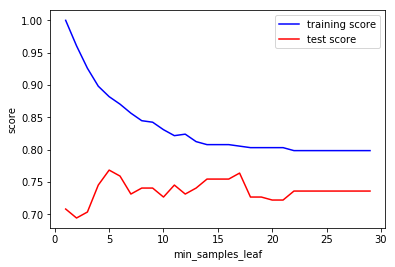

In [29]:
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'Kept', 'UI', 'GI', 'CurrentTitle'])].values
X = df[features]
y = df['Kept']

# Vary the minimum numbers of samples in each leaf of the decision tree and find optimal value. Increasing this amount decreases variance.
# Find the score from nested cross-validation and grid search
clf = GridSearchCV(tree.DecisionTreeClassifier(), {'min_samples_leaf':np.arange(1,30)}, return_train_score=True)
scores = cross_val_score(clf,X,y)
print("Cross-Validation Score: {:.0%}+/-{:.0%}\n".format(scores.mean(), scores.std()))

# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)

print('Validation Curve plot as min_samples_leaf varies')
plt.plot(clf.cv_results_['param_min_samples_leaf'], clf.cv_results_['mean_train_score'], color='blue', label='training score')
plt.plot(clf.cv_results_['param_min_samples_leaf'], clf.cv_results_['mean_test_score'], color='red', label='test score')
plt.legend(loc='best')
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.show()

# Accuracy Checking

Confusion Matrix and Classification Report

In [30]:
# Confusion matrix and Classification Report for all folds in a K-fold Cross-validation  
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

print('\nClassification Report')
print(classification_report(y_act, y_pred)) 


Confusion Matrix


Predicted,Cancelled,Kept,All
Actual,,,
Cancelled,7,9,16
Kept,15,41,56
All,22,50,72



Classification Report
             precision    recall  f1-score   support

  Cancelled       0.32      0.44      0.37        16
       Kept       0.82      0.73      0.77        56

avg / total       0.71      0.67      0.68        72



## Display Tree

Best Decision Tree


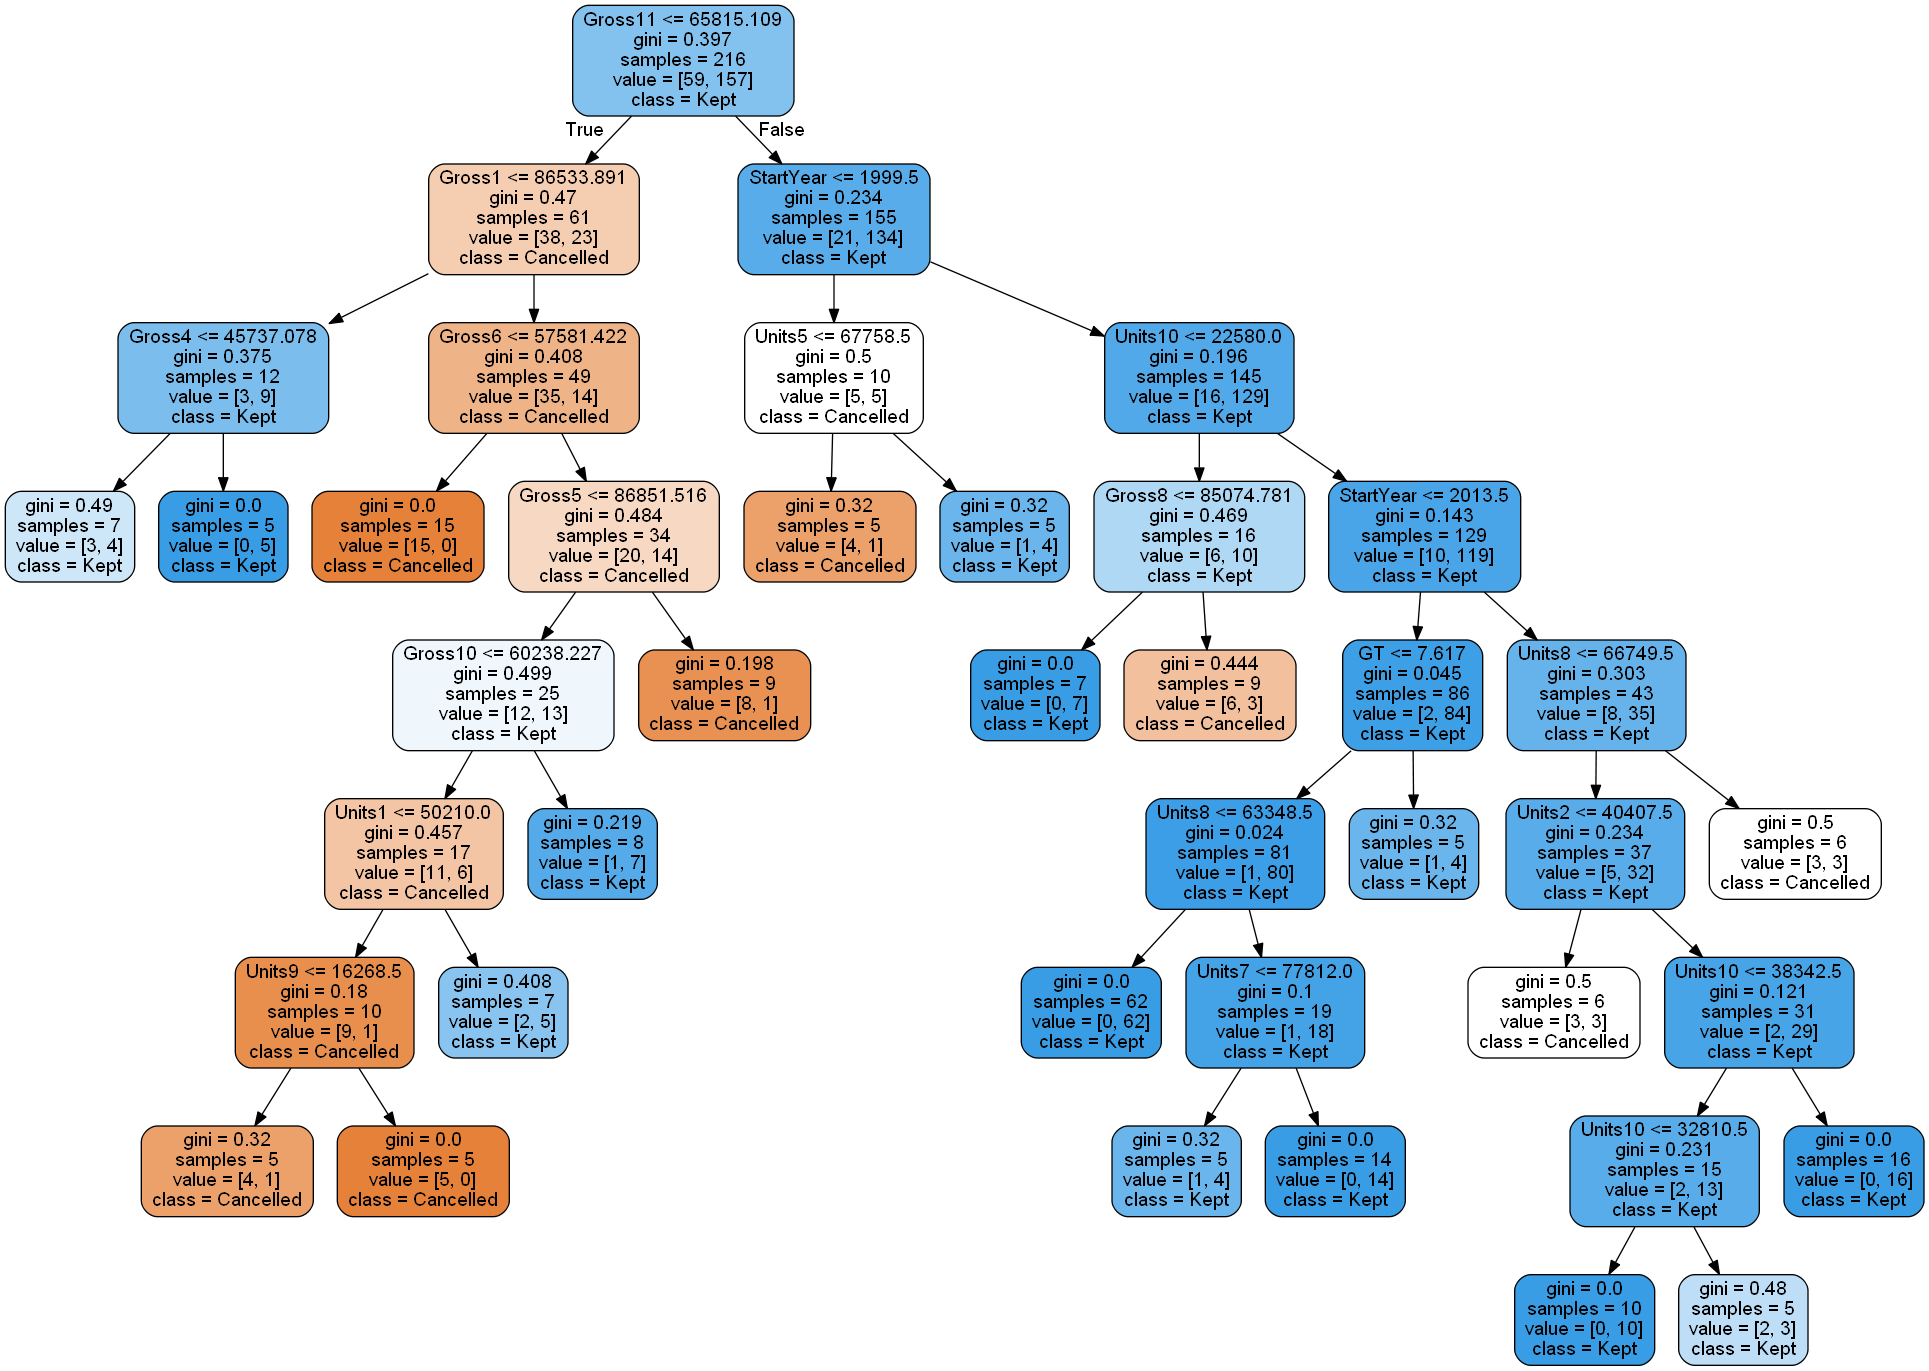

In [32]:
# Display the decision tree from the fit
print('Best Decision Tree')
dot_data = export_graphviz(clf.best_estimator_, out_file='tree.dot', feature_names=features, class_names=['Cancelled', 'Kept'], filled=True, rounded=True,  )
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
display(Image("tree.png"))

## Most Important Features

Most Important Features


,Importance
Gross11,0.374459
StartYear,0.078482
Gross1,0.074804



Fit to top two most important features


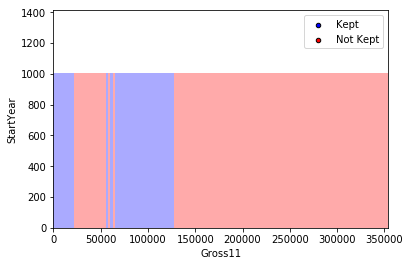

In [34]:
# Show the most important features and use plotDataClassification on those features
print('Most Important Features')
features_importance = pd.DataFrame(clf.best_estimator_.feature_importances_, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
display(features_importance.head(3))

# Plot the fit to the the two most important features
print('\nFit to top two most important features')
features = features_importance.iloc[0:2].index.values
plotClassification2D(df, features, 'Kept', clf.best_estimator_)

## Variable Correlations

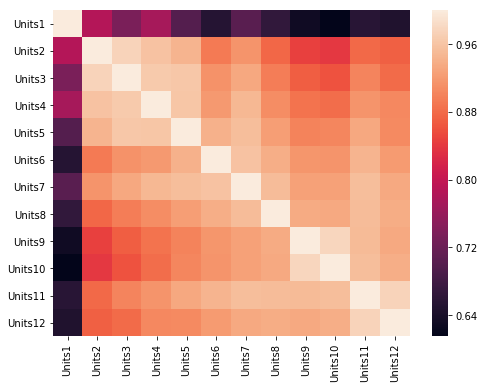

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(df.iloc[:,2:14].corr())

# 2. Random Forests

In [ ]:
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'Kept', 'UI', 'GI', 'CurrentTitle'])].values
X = df[features]
y = df['Kept']

params = {'min_samples_leaf' : np.arange(1,21,2), 'max_features' : np.arange(1,8)}
clf = GridSearchCV(RandomForestClassifier(n_estimators = 100), params, return_train_score=True)
scores = cross_val_score(clf,X,y)
print("Cross-Validation Score: {:.0%}+/-{:.0%}\n".format(scores.mean(), scores.std()))


# Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf.fit(X_train, y_train)

print('Validation Curve plot as each param varies')
results = pd.DataFrame(clf.cv_results_)
params = list(params.keys())
for p in params:
    r = results.copy()
    not_p = params.copy()
    not_p.remove(p)
    for x in not_p:
        r = r[r['param_' + x] == clf.best_params_[x]]

    plt.plot(r['param_' + p], r['mean_train_score'], color='blue', label='training score')
    plt.plot(r['param_' + p], r['mean_test_score'], color='red', label='test score')
    plt.legend(loc='best')
    plt.xlabel(p)
    plt.ylabel('score')
    plt.show()

## Confusion Matrix

In [ ]:
# Confusion matrix and Classification Report for all folds in a K-fold Cross-validation  
print('\nConfusion Matrix')
y_pred = pd.Series(clf.predict(X_test), name='Predicted').replace({0: 'Cancelled', 1: 'Kept'})
y_act = pd.Series(y_test.values, name='Actual').replace({0: 'Cancelled', 1: 'Kept'})
display(pd.crosstab(y_act, y_pred, margins=True))

print('\nClassification Report')
print(classification_report(y_act, y_pred)) 

In [37]:
## Important Features

In [ ]:
# Show the most important features and use plotDataClassification on those features
print('Most Important Features')
features_importance = pd.DataFrame(clf.best_estimator_.feature_importances_, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
display(features_importance.head(10))

## 2D Classification Plot

In [ ]:
features = ['Units10', 'Units6']
X = df[features]
y = df['Kept']

clf = RandomForestClassifier(n_estimators=100)
plotDataClassification(features, clf)
scores = cross_val_score(clf, X, y, cv=3)
print('Cross-Validation Score: {:.1%}'.format(scores.mean()))

# 3. Other Classifiers

I'll try a variety of other machine learning methods to determine whether they would be more better classifiers for this data.

## K-Nearest Neighbors (KNN)

In [ ]:
# Determine best number of neighbors to prevent overfitting and calculate cross-validation score
features = df.columns[~df.columns.isin(['Title','MaxIssue', 'Kept', 'UI', 'GI'])].values
features = ['Units10','Units1']
X = df[features]
y = df['Kept']

scores = np.zeros(20)
for i in range(1, 21):
    clf = neighbors.KNeighborsClassifier(n_neighbors = i, weights='distance')
    clf.fit(X, y)
    scores[i-1] = np.mean(cross_val_score(clf, X, y, cv=3))

plt.plot(scores)
plt.xlabel('K Neighbors')
plt.ylabel('Cross validation Score')
plt.show()
print('Max Score: {:.2} when min_samples_leaf = {}'.format(np.max(scores), np.argmax(scores)+1))

# Using best number of neighbors, plot classification plot using the same features found to be important with Decision Trees
clf = neighbors.KNeighborsClassifier(n_neighbors = np.argmax(scores)+1, weights='distance')
# clf = neighbors.KNeighborsClassifier(n_neighbors = 20, weights='distance')

plotClassification2D(cf, ['Units10','Units1'], 'Kept', clf)

## Support Vector Machines (SVM)


In [ ]:
# features = df.columns[~df.columns.isin(['Title','MaxIssue', 'Kept', 'UI', 'GI', 'CurrentTitle'])].values
features = ['Units10', 'Units6']
X = df[features]
y = df['Kept']

clf = svm.SVC(kernel='linear', C=1)
plotClassification2D(df, features, 'Kept', clf)

## Quadratic Discriminant Analysis

In [ ]:
clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
plotClassification2D(df, ['Units10','Units5'], 'Kept', clf)


# 4. Conclusion